# SEM Particle counting - Notebook demo
This notebook demonstrates code that allows you to semi-automate SEM particle counting.

### Module import

In [5]:
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import cv2

from os import walk                       # To get filepaths automatically
import counting_functions as cf           # Custom functions written for this program

In [6]:
%matplotlib qt

### Select file(s)
- Either specify the folder from which you wish to analyse all images, or specify a full filepath

In [7]:
# Automatically get all filepaths in example folder
fpaths = []
folder = r'example_data/'
_, _, fnames = next(walk(folder))
for fname in fnames:
    fpaths.append(folder+fname)
    
# Or specify a specific filepath:
# fpath = r'C:\Users\grl31\Dropbox (Cambridge University)\Elizabeth & George\Size counting\LN-010\LN-010_004.tif'

## 1. Brief demo

- In theory, the program should be as simple as this.
- Simply call the 'full_count_process' on a filepath and you will be returned an image showing the identified shapes with their calibrated diameter + error in the legend.
- The identification will not be perfect, but hopefully it will be quick for you to identify the shapes that have been correctly labelled.

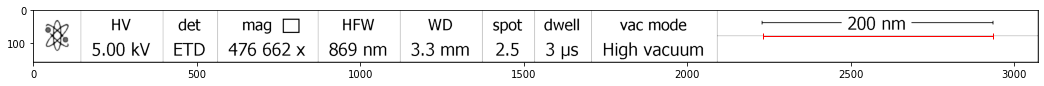

Please enter scalebar value in nm:  200


200 nm in 706 px, pixel width = 0.283 nm


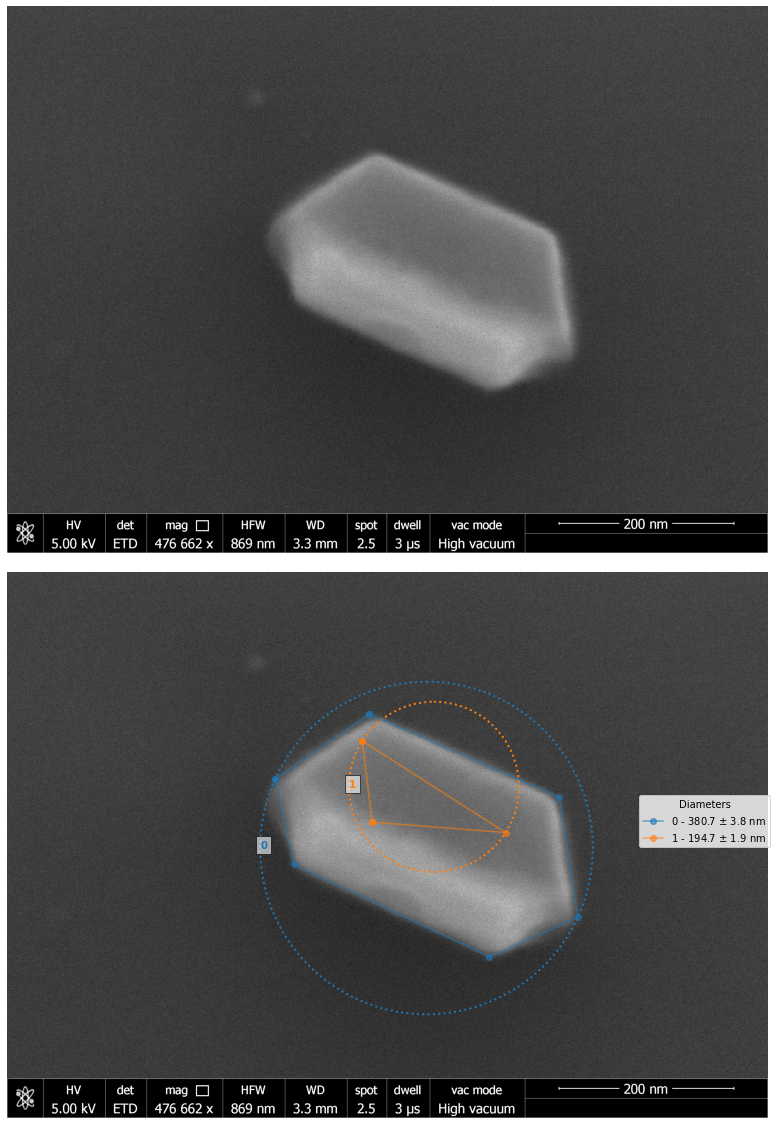

In [3]:
cf.full_count_process(fpaths[0])

- If you want see that the algorithm has identified lots of shapes that are too small, you can adjust the 'min_avg_length' keyword to specify a larger threshold in nm
- To output the lengths/errors, set 'return_vals' to True

(array([198.82275797, 222.12809953, 272.75513935, 240.11176049,
        249.98262997, 279.88198268]),
 array([1.98822758, 2.221281  , 2.72755139, 2.4011176 , 2.4998263 ,
        2.79881983]))

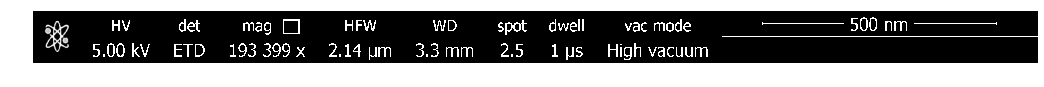

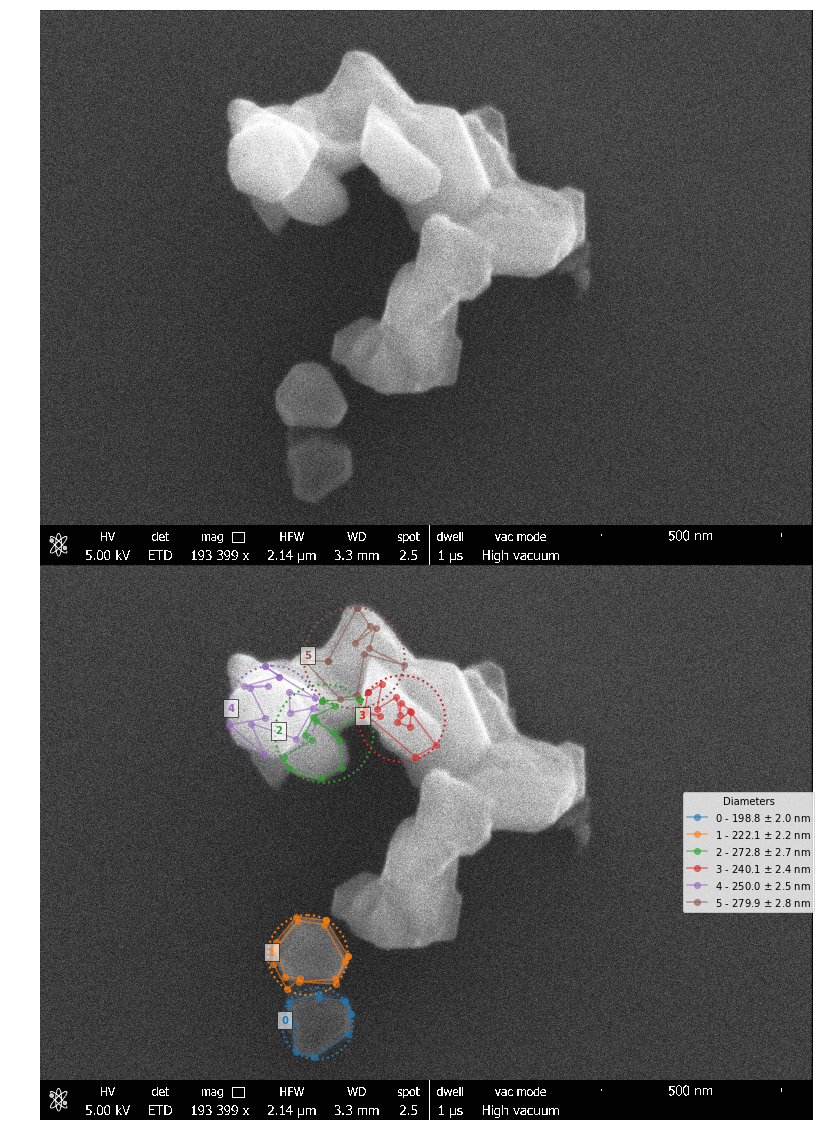

In [6]:
cf.full_count_process(fpaths[0],min_avg_length=50,return_vals=True)

- If the calibration metadata is not present in the file, then the program will automatically try to locate the scalebar.
    - You will then be presented with a cropped image of the scalerbar with the location attempt plotted in red. 
    - You will be prompted to type in the scalebar value in nm (if this is known in advance then you can bypass this using the 'scale_bar_val' keyword).

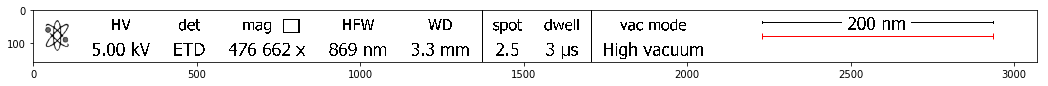

Please enter scalebar value in nm:  200


200 nm in 706 px, pixel width = 0.283 nm


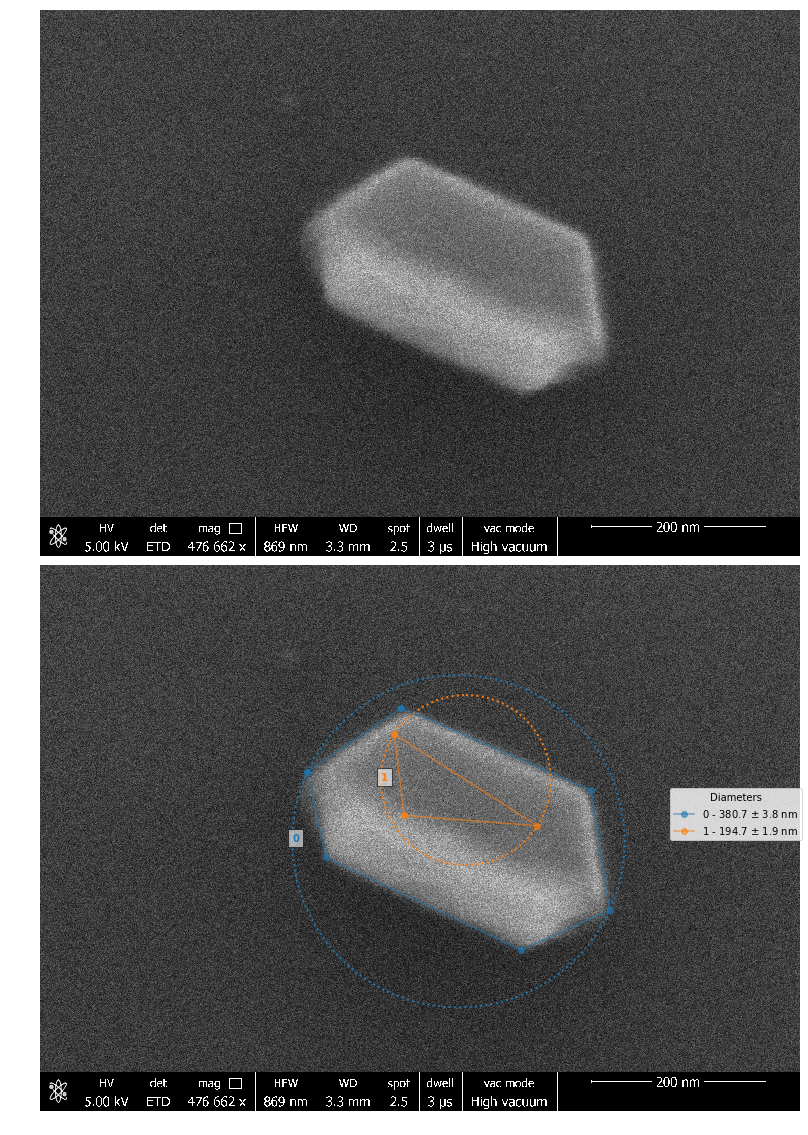

In [5]:
cf.full_count_process(fpaths[3])

- If the filter is not performing well, you can choose to return the filtered images to see what is happening

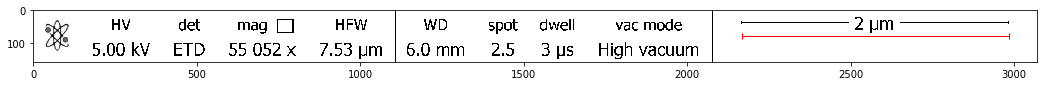

2000 nm in 816 px, pixel width = 2.451 nm


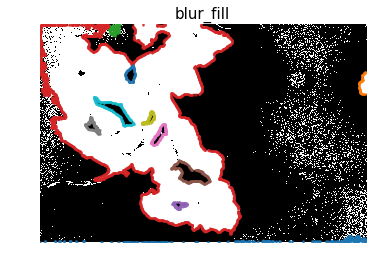

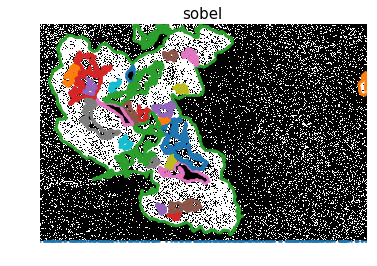

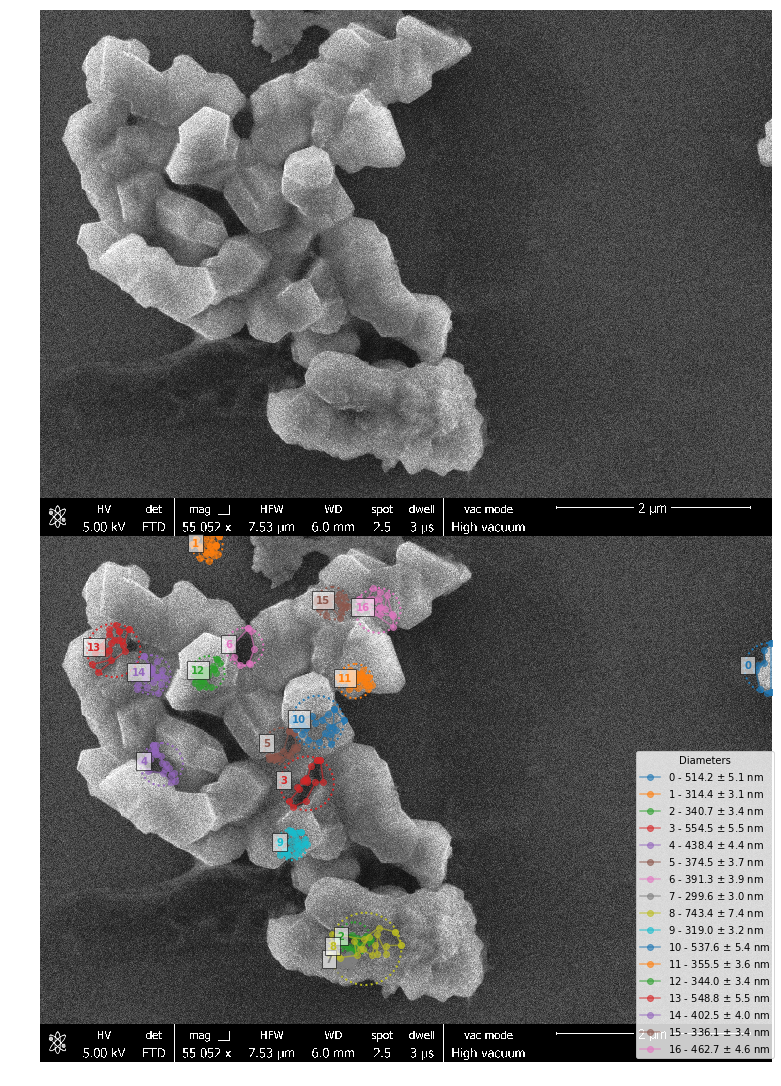

In [4]:
cf.full_count_process(fpaths[2],plot_filters=True,scale_bar_val=2000)

- If the filter is failing then you can swap to manual input by passing 'manual' = True
- In this mode:
    - Left click to add points around the edge of a shape (up to 6 points).
    - Middle click to remove a point added by mistake
    - Right click to move to defining the next shape
    - Right click twice to finish
- The program will then use these points as contours and continue the same as before

In [136]:
cf.full_count_process(fpaths[2],manual=True)

Please enter scalebar value in nm:  500


500 nm in 816 px, pixel width = 0.613 nm
Pyplot backend: Qt5Agg
Pyplot backend: module://ipykernel.pylab.backend_inline


# 2. In-depth demo
- This section walks through what each of the main functions in the program do and how they work

### Load image
- The first stage is to load and calibrate the image.
- This is straightforward for images with metadata, but otherwise the manual calibration will kick-in - we can see some of what it does using 'show_cal=True'
    - First a vertical Sobel filter is used to find the row with the largest gradient change - this will always be the boundary between the image and scalebar unless your image is literall of black/white horizontal stripes. This allows the image to be cropped into image/scalebar sections
    - The program then sums the scalebar image in the vertical direction to get a row of intensities.
    - It then looks for a region (at least 80 continuous pixels) where this sum is the same in every position.
    - The start of this region is the LHS of the scalebar and the end is the RHS of the scalebar - 80 pixels.

In [3]:
# Read, calibrate, and view image
im,raw_im,px,w,h = cf.read_tif(fpaths[0],show_cal=True)
#plt.imshow(im)

NameError: name 'cf' is not defined

### Filter
- The next step is to apply filters to the image. We need a combination of filters to highlight different aspects of the image. 
- The filters need to produce a binary image which contours can then be fitted around the edge of each region in the binary image.
    - The first filter 'blur_fill' preprocesses just with a slightly blur and then uses a simple threshold to binarise the image.
    - An 'erode'/'grow' process is then used to remove small islands/fill holes
    - A basic perimeter/area filter is used also to ensure the tiny spots in the image are not added to the contour list
    - This filter will be good at finding isolated shapes

In [63]:
%matplotlib qt
im = cv2.imread(fpaths[0],0)

#ret1,th1 = cv2.threshold(im,60,255,cv2.THRESH_BINARY)
#im = im.astype(np.uint8)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

#thresh = thresh.astype(np.uint8)
#thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
plt.imshow(thresh,interpolation=None,cmap='Greys')
plt.colorbar()
np.shape(im),np.shape(thresh)

NameError: name 'blurred' is not defined

In [63]:
_,contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#contours, hierarchy = cv2.findContours(binary,cv2.RETR_FLOODFILL,cv2.CHAIN_APPROX_SIMPLE)


In [62]:
big_cnt = []
for c in contours:
    area = cv2.contourArea(c)
    perim = cv2.arcLength(c,True)
    if area > 3000 or perim > 2000:
        big_cnt.append(c)
        
cf.plot_contours(big_cnt,im)

In [12]:
# Extract contours
c1 = cf.extract_contours(im,method='blur_fill',plot=True)



- The second filter uses an edge detection algorithm - this will be better at finding structures within an agglomerated region
    - A sobel edge detection routine is called in x and y directions and then summed.
    - After this the process is the same as the first filter

In [65]:
c2 = extract_contours(im,method='sobel',plot=True)

NameError: name 'extract_contours' is not defined

### Simplify contours
- The next step simplifies each contour to a polygon approximation.
- By default this needs to match the original perimeter to within 1% and this is what (naively) leads to the final error on the measurement

In [13]:
# simplify contours to shapes
s1 = cf.detect_shapes(c1)
plot_shapes(s1,im)

np.shape(s1)

NameError: name 'plot_shapes' is not defined

(12,)

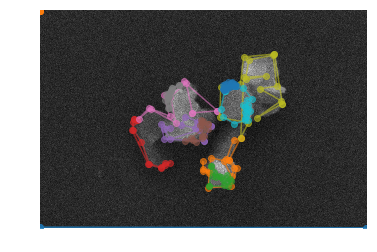

In [42]:
s2 = detect_shapes(c2)
plot_shapes(s2,im)

np.shape(s2)

### Merge filtered shapes and remove identical shapes
- The next step concatantes shapes from multiple filters together
- It then uses an algorithm to remove shapes that match certain characteristics above a % threshold.
    - Characteristics: Perimeter, Area, Centre of bounding circle, Radius of bounding circle
    - Threshold: By default is set to a 30% match

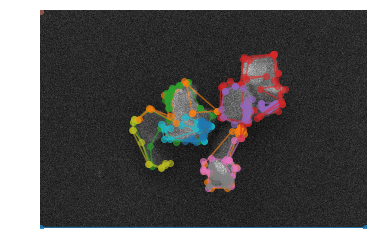

In [43]:
# Merge shapes from different filters together
all_s =np.concatenate((s1,s2))
new_all_s = remove_identical_shapes(all_s,threshold=.3)
plot_shapes(new_all_s,im)

### Filter out bad shapes
- At this stage, a filter is applied to try and remove silly shapes
    - This includes any shape with less than 3 vertices.
    - This also includes shapes with a min/max average length below/above the default thresholds of 30 nm/150 nm

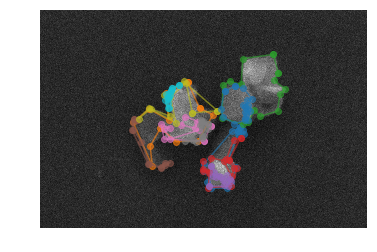

In [45]:
# remove weird shapes
filtered = post_filter(new_all_s,px)
plot_shapes(filtered,im)

### Measurement and plotting
- In this final step, a minimum enclosing circle is fit to each shape, and the calibrated diameter and corresponding errors are calculated.
- These are then plotted over the image, with the diameters given in the legend

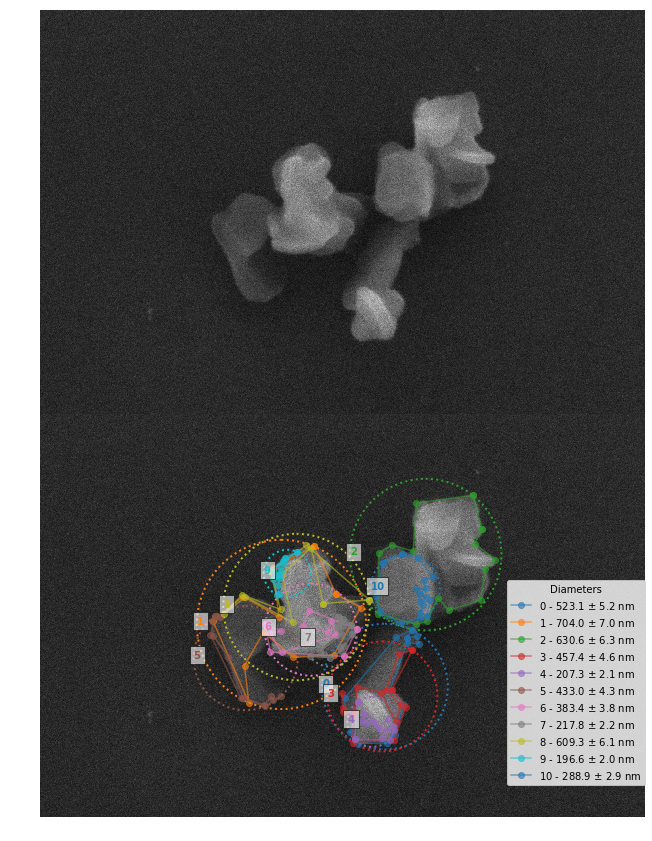

In [107]:
# Plot final measurements
poly_approx_thresh = 0.01
cents,rads = fit_circles(filtered)
ds = calibrate_radii(rads,px)
errs = np.array(ds) * poly_approx_thresh
plot_circles(im,filtered,cents,rads,ds,errs)

In [ ]:

fig,ax = plt.subplots()
ax.imshow(im)

data = []
def mouseClick(event):
    global data
    if event.button == 1:
        # store click and plot point
        plt.plot(event.xdata,event.ydata,'r+')
        data.append([event.xdata,event.ydata])
    if event.button == 2:
        # remove last point from data
        p = data[-1]
        plt.plot(p[0],p[1],'wx')
        data.pop()
    if event.button == 3:
        # stop the input
        fig.canvas.mpl_disconnect(cid)

fig.canvas.draw()

timeout = 10   # [seconds]

timeout_start = time.time()
cid = plt.connect('button_press_event', mouseClick)
plt.show()
while True:
    if time.time() < timeout_start + timeout:
        fig.canvas.draw()
    else:
        fig.canvas.mpl_disconnect(cid)
        break
    #plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
%matplotlib qt5
fig,ax = plt.subplots()
ax.imshow(im)
fig.ginput(n=20, show_clicks=True,mouse_stop=3,mouse_pop=2,timeout=10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyboardInterrupt: 

In [2]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib qt
plt.imshow(np.ones((100,100)))

In [18]:
%matplotlib qt
import types # for scroll
im,raw_im,px,w,h = cf.read_tif(fpaths[2],show_cal=True,scale_bar_val=100)
def zoom_factory(ax,base_scale=60):
    """ Allow zooming with the scroll wheel on pyplot figures 
         Pass figure axes and a scrolling scale. 
         Based on https://stackoverflow.com/questions/11551049/matplotlib-plot-zooming-with-scroll-wheel """
    
    def mousewheel_move( event):
        ax=event.inaxes
        ax._pan_start = types.SimpleNamespace(
                lim=ax.viewLim.frozen(),
                trans=ax.transData.frozen(),
                trans_inverse=ax.transData.inverted().frozen(),
                bbox=ax.bbox.frozen(),
                x=event.x,
                y=event.y)
        ax.figure.canvas.toolbar.push_current() # Ensure toolbar home stays the same
        
        # Note using ax.drag_pan is much faster than resetting axis limits
        if event.button == 'up':
            ax.drag_pan(3, event.key, event.x+base_scale, event.y+base_scale)
        else: #event.button == 'down':
            ax.drag_pan(3, event.key, event.x-base_scale, event.y-base_scale)
        fig=ax.get_figure()
        fig.canvas.draw_idle()
    
    fig = ax.get_figure()
    fig.canvas.mpl_connect('scroll_event',mousewheel_move)
    
    return mousewheel_move

fig, ax = plt.subplots()
ax.imshow(im)
scale = 60
f = zoom_factory(ax,base_scale = scale)

2168 2984 479232 288768
100 nm in 816 px, pixel width = 0.123 nm


In [29]:
class ZoomPan:
    def __init__(self):
        self.press = None
        self.cur_xlim = None
        self.cur_ylim = None
        self.x0 = None
        self.y0 = None
        self.x1 = None
        self.y1 = None
        self.xpress = None
        self.ypress = None
        
    def zoom_factory(self, ax, base_scale = 2.):
        def zoom(self, event, factor):
            curr_xlim = self.ax.get_xlim()
            curr_ylim = self.ax.get_ylim()

            new_width = (curr_xlim[1]-curr_ylim[0])*factor
            new_height= (curr_xlim[1]-curr_ylim[0])*factor

            relx = (curr_xlim[1]-event.xdata)/(curr_xlim[1]-curr_xlim[0])
            rely = (curr_ylim[1]-event.ydata)/(curr_ylim[1]-curr_ylim[0])

            self.ax.set_xlim([event.xdata-new_width*(1-relx),
                        event.xdata+new_width*(relx)])
            self.ax.set_ylim([event.ydata-new_width*(1-rely),
                                event.ydata+new_width*(rely)])
            self.draw()

        fig = ax.get_figure() # get the figure of interest
        fig.canvas.mpl_connect('scroll_event', zoom)

        return zoom

In [31]:
fig, ax = plt.subplots()
ax.imshow(im)
ZoomPan.zoom_factory(self,ax)

NameError: name 'self' is not defined

In [32]:
import types
def mousewheel_move( event):
    ax=event.inaxes
    ax._pan_start = types.SimpleNamespace(
            lim=ax.viewLim.frozen(),
            trans=ax.transData.frozen(),
            trans_inverse=ax.transData.inverted().frozen(),
            bbox=ax.bbox.frozen(),
            x=event.x,
            y=event.y)
    if event.button == 'up':
        ax.drag_pan(3, event.key, event.x+10, event.y+10)
    else: #event.button == 'down':
        ax.drag_pan(3, event.key, event.x-10, event.y-10)
    fig=ax.get_figure()
    fig.canvas.draw_idle()

8

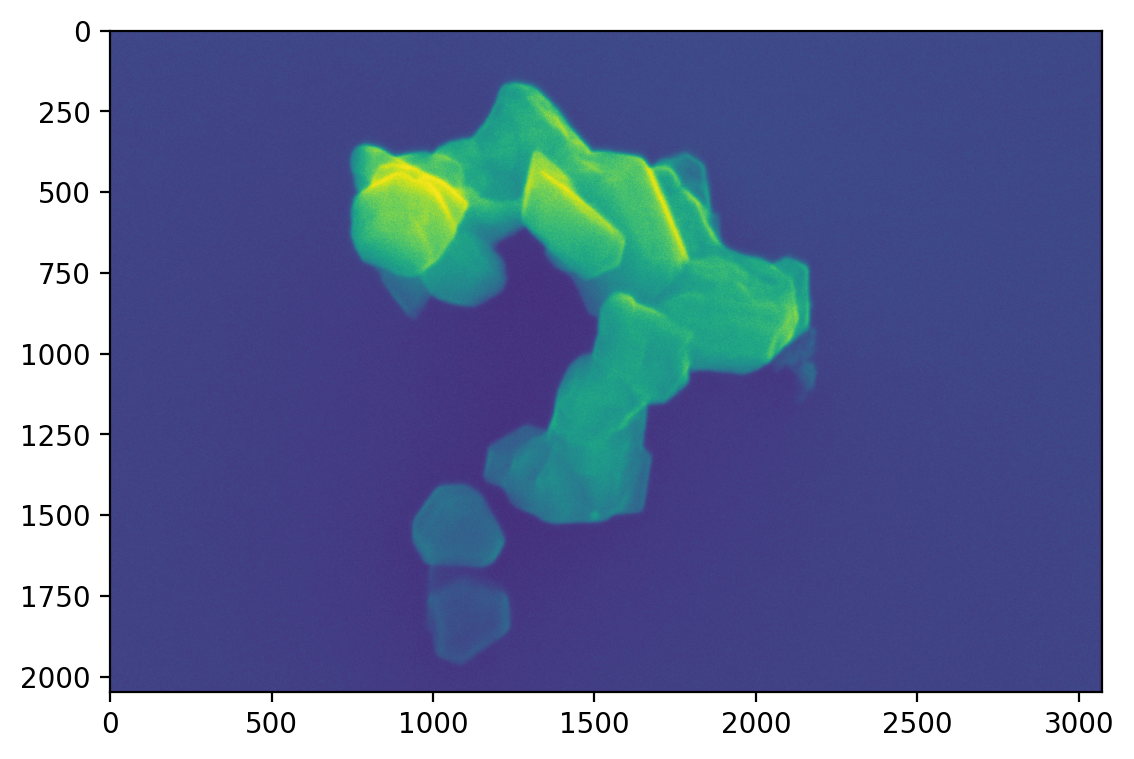

In [33]:
fig, ax = plt.subplots()
ax.imshow(im)
fig.canvas.mpl_connect('scroll_event',mousewheel_move)

In [52]:
a = ['a','b']
str(a)

"['a', 'b']"

In [146]:
def manual_detection(im,max_shapes=20):
    """ Manually click out the boundary of a shape in the event that auto-filtering fails"""
    cf.swap_pyplot_backend(plot_inline=False)
    # Show image
    plt.imshow(im,cmap='Greys_r')
    plt.axis('off')
    
    all_points = []
    all_s = []
    # Get user input
    points = plt.ginput(n=20, show_clicks=True,mouse_stop=3,mouse_pop=2)
    if points == []:
        pass
    else:
        all_points.append(points)
        points2 = np.copy(points)
        points2.append(points[-1]))
        all_points.append(points[-1])
        # Convert points to contour
        s = np.array(points).reshape((-1,1,2)).astype(np.int32)
        all_s.append(s)
        
        s2 = np.array(points2).reshape((-1,1,2)).astype(np.int32)
        all_s.append(s2)
    #all_s.append(s)

            # Plot shape
#             x1,x2 = s[:][0,0][0],s[:][-1,0][0]
#             y1,y2 = s[:][0,0][1],s[:][-1,0][1]
#             plt.plot(s[:,0][:][:,0],s[:,0][:][:,1],'o-',color='r',alpha=.6)
#             plt.plot([x1,x2],[y1,y2],'o-',color='r',alpha=.6,label=None)
        
    plt.close()
    
#     points2 = np.concatenate((points,points[-1]))
#     s2 = np.array(points2).reshape((-1,1,2)).astype(np.int32)
#     all_s.append(s2)
    #swap_pyplot_backend(plot_inline=True)
    return points

In [147]:
%matplotlib qt
out = manual_detection(im)

Pyplot backend: Qt5Agg


In [151]:
a = out.append(out[-1])

In [152]:
a

In [150]:
out

[(321.5645161290322, 1649.384516129032),
 (909.9516129032259, 1104.3522580645158),
 (1585.0483870967741, 1333.5135483870965),
 (1585.0483870967741, 1333.5135483870965)]

In [117]:
cv2.drawContours(raw_im,[out,out2],0,(255,255,255),1)
cv2.imshow('output',raw_im)

In [90]:
previous = s1

In [108]:
previous.append(np.array(out,dtype=np.int32))
cf.fit_circles(previous)

([(1104.4892578125, 1823.2178955078125),
  (1119.0, 1868.0),
  (1079.659912109375, 1543.988525390625),
  (1463.0, 736.5),
  (1.0, 5.5),
  (1073.5, 1149.2227783203125),
  (1307.2843017578125, 945.6917724609375),
  (1213.0, 1110.0),
  (1213.0, 1110.0),
  (1213.0, 1110.0),
  (1213.0, 1110.0),
  (1213.0, 1110.0)],
 [142.5250701904297,
  76.47885131835938,
  148.0460662841797,
  805.7905883789062,
  4.609872341156006,
  744.0639038085938,
  382.92535400390625,
  410.7579345703125,
  410.7579345703125,
  410.7579345703125,
  410.7579345703125,
  410.7579345703125])

In [107]:
np.shape(previous)

(11,)

In [17]:
np.shape(s2)

(6,)

In [148]:
np.shape(s2[0]),np.shape(out[0]),np.shape(c1[0])

((12, 1, 2), (3, 1, 2), (12, 1, 2))

In [39]:
cf.fit_circles(np.delete(a,0))

([(643.0, 1125.5)], [442.45037841796875])

In [82]:
out

all_s = np.array([out2,out2])
try:
    all_s = all_s#.tolist()
except:
    all_s = []
    
try:
    all_s.append(out)
    all_s = np.array(all_s)
    cf.fit_circles(all_s)
   
except:
    all_s = np.append(all_s,np.reshape(out5,(1,3,1,2)))
    #all_s = np.ones_like
    #out5 = np.reshape(out,(1,3,1,2))
    #all_s = np.concatenate((all_s,out5),axis=0)
    all_s = np.array(all_s)
    cf.fit_circles(all_s)

TypeError: Expected Ptr<cv::UMat> for argument 'points'

In [80]:
np.shape(all_s),np.shape(out)

((22,), (1, 3, 1, 2))

In [84]:
out2

array([[[ 371, 1005]],

       [[ 371, 1575]],

       [[1219, 1358]],

       [[1120, 1079]]])

In [6]:
import numpy as np
fpath = 'C:/Users/grl31/Documents/GitHub/phd-work/particle-counter/test.csv'
split = fpath.split(sep='/')
folder = ''
for i in split[:-1]:
    folder += i + '/'
    
folder

'C:/Users/grl31/Documents/GitHub/phd-work/particle-counter/'

In [9]:
from os import walk
folder = r'example_data/'
_, _, fnames = next(walk(folder))
fnames

['LN-010_004.tif',
 'LN-050_014.tif',
 'LN-200_015.tif',
 'PE-PEEK_009.tif',
 'PE-PEEK_011.tif']

In [12]:
split[-1].split(sep='.')[0]

'test'

In [16]:
import csv
with open('eggs.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Size / nm'] + ['fpath'])

In [17]:
with open('eggs.csv', 'a', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['col 4'] + ['col 5'])

In [22]:
name = 'abc.d'
name.split('.')[1]

'd'

In [24]:
files = ['a','b','c','d']
i = 1
len(files)
files[4]

IndexError: list index out of range

In [1]:
import numpy as np


In [5]:
from PyQt5 import QtWidgets, uic, QtGui
from PyQt5.QtCore import QObject# GUI functions
import sys                                                                                    # For interacting with computer OS
from os import walk                                                                           # To get filepaths automatically
import numpy as np                                                                            # Maths
import matplotlib.pyplot as plt                                                               # Plotting
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas              # 'Canvas' widget for inserting pyplot into pyqt
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar      # Toolbar widget to accompany pyplot figure
import gui_counting_functions as cf                                                               # Custom functions for shape this program
import types # for scroll
import csv # for saving
import time # for notifying
from datetime import datetime

# Set fake Windows App ID to trick taskbar into displaying icon
import ctypes

In [6]:
import cv2                                # Image processing
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import copy                               # Deepcopy function
import tifffile                           # Reading tif images
from os import walk                       # Get filepaths automatically
import warnings
warnings.filterwarnings("ignore")         # Remove unnecessary pyplot warnings
import matplotlib
